In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2


In [2]:
fluxes = pandas.read_csv("./predictions/KT2440-UPF36-DLKcat-Transport10-R2A.csv",index_col=0)

In [3]:
pred = fluxes[fluxes.index.str.contains("translation_")]["fluxes"]*1e9
pred.name = "predicted"
pred.index = [r.split("translation_")[-1] for r in pred.index]

### Load omics data

In [4]:
rna = pandas.read_csv("./data-jul-2024/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [5]:
ribo = pandas.read_csv("./data-jul-2024/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [37]:
Results = ribo.join(rna,rsuffix="_rna").join(pred).dropna()
Results.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,predicted
PP_0953,8602,8370,4895,56.0,184.0,210.0,17.474251
PP_0954,8684,8244,3366,241.0,464.0,436.0,17.474251
PP_0955,19510,22461,6913,367.0,273.0,298.0,17.474251
PP_0956,7302,5258,4122,30.0,63.0,50.0,277.655540
PP_0957,15224,14182,8317,75.0,180.0,210.0,0.000000


In [38]:
ResultsLog = numpy.log10(Results).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
samples = ["PPutida_1","PPutida_2","PPutida_4"]
rna_samples = [s+"_rna" for s in samples]
colors = ["#2b83ba","#66bd63","#fdae61"]

/home/jt/venvs/coralme/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


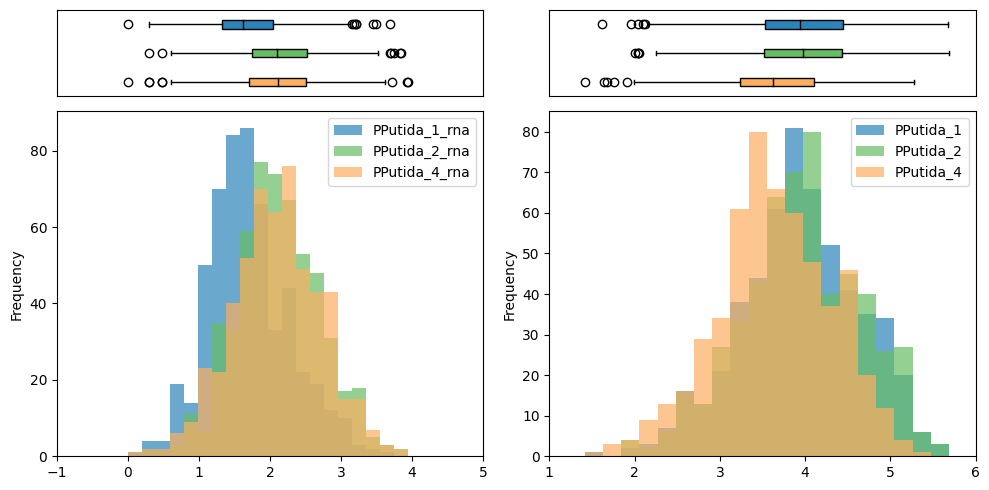

In [39]:
import matplotlib.ticker as ticker
alpha = 0.7
fig,ax = plt.subplots(2,2,figsize=(10,5),gridspec_kw={'height_ratios': [1,4]})
_,props = ResultsLog[rna_samples[::-1]].plot.box(vert=False,ax=ax[0,0],patch_artist=True,return_type='both',color="black")
for patch,color in zip(props['boxes'],colors[::-1]):
    patch.set_facecolor(color)
ResultsLog[rna_samples].plot.hist(alpha=alpha,bins=20,ax=ax[1,0],color=colors)
_,props = ResultsLog[samples[::-1]].plot.box(vert=False,ax=ax[0,1],patch_artist=True,return_type='both',color="black")
for patch,color in zip(props['boxes'],colors[::-1]):
    patch.set_facecolor(color)
ResultsLog[samples].plot.hist(alpha=alpha,bins=20,ax=ax[1,1],color=colors)

ax[0,0].xaxis.set_major_locator(ticker.NullLocator())
ax[0,0].yaxis.set_major_locator(ticker.NullLocator())
ax[0,1].xaxis.set_major_locator(ticker.NullLocator())
ax[0,1].yaxis.set_major_locator(ticker.NullLocator())

for a in ax[:,0]:
    a.set_xlim([-1,5])

for a in ax[:,1]:
    a.set_xlim([1,6])

fig.tight_layout()
fig.savefig("./figures/omics-distributions.svg")

### Comparing

In [34]:
from scipy.stats import ttest_ind
def ttest(slist):
    # slist = samples
    dct = {}
    for i in slist:
        dct[i] = {}
        for j in slist:
            dct[i][j] = ttest_ind(Results[i],Results[j],alternative="two-sided").pvalue
    return pandas.DataFrame.from_dict(dct)

In [35]:
import seaborn as sns

/tmp/ipykernel_478507/4169779232.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


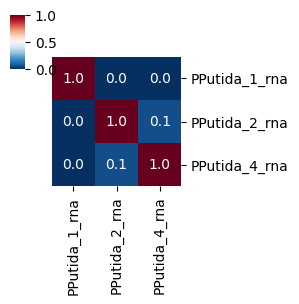

In [36]:
cmap_df = ttest(rna_samples)
cmap = plt.cm.get_cmap('RdBu_r').copy()
cmap.set_under('white')
# vmin,vmax = (1.0,2)
cmap = sns.clustermap(cmap_df,
               row_cluster=False,
               col_cluster=False,
               # vmin=vmin,
               # vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               figsize=(3,3),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]
# plt.savefig("./figures/mw-te-colorbar.svg",format="svg")

/tmp/ipykernel_478507/997947813.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


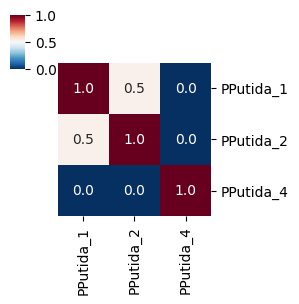

In [29]:
cmap_df = ttest(samples)
cmap = plt.cm.get_cmap('RdBu_r').copy()
cmap.set_under('white')
# vmin,vmax = (1.0,2)
cmap = sns.clustermap(cmap_df,
               row_cluster=False,
               col_cluster=False,
               # vmin=vmin,
               # vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               figsize=(3,3),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]
# plt.savefig("./figures/mw-te-colorbar.svg",format="svg")

In [408]:
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr

0.5426115044404258 PearsonRResult(statistic=0.7366216833900736, pvalue=4.0190592644137704e-94)
0.7388238886541181 PearsonRResult(statistic=0.8595486540354292, pvalue=3.8828730991291785e-160)
0.7610475768824815 PearsonRResult(statistic=0.8723804083554844, pvalue=1.3067238856585968e-170)


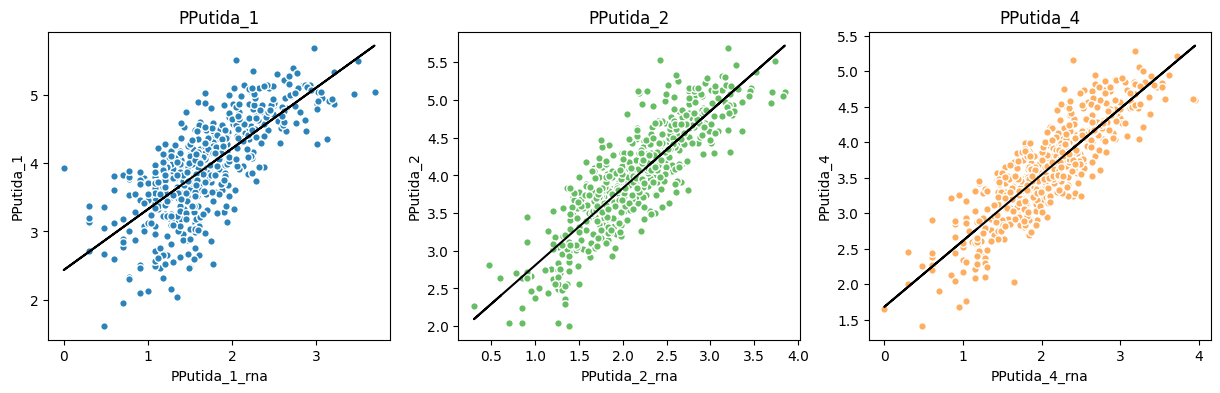

In [409]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
for s,a,c in zip(samples,ax,colors):
    rna = s+"_rna"
    X = ResultsLog[rna].values
    y = ResultsLog[s].values
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    # print(est2.summary())
    print(est2.rsquared,pearsonr(y,est2.predict()))
    ResultsLog.plot.scatter(x=rna,y=s,ax=a,color=c,edgecolors='white',s=30)
    a.plot(X,est2.predict(),color="black")
    a.set_title(s)
fig.savefig("./figures/sample-rna-vs-ribo.svg")

### Performance with riboseq

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     406.7
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           6.39e-81
Time:                        16:28:02   Log-Likelihood:                -1560.6
No. Observations:                1632   AIC:                             3125.
Df Residuals:                    1630   BIC:                             3136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6134      0.019    186.382      0.0

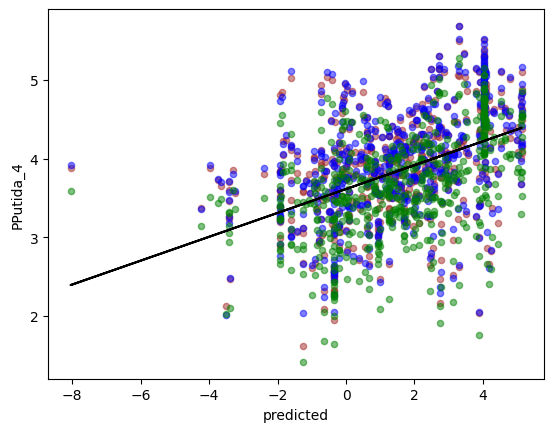

In [401]:
import statsmodels.api as sm
from scipy import stats

tmp = numpy.log10(Results).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()

X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[["PPutida_1","PPutida_2","PPutida_4"]].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
fig,ax = plt.subplots(1,1)
tmp.plot.scatter("predicted","PPutida_1",ax=ax,color="brown",alpha=0.5)
tmp.plot.scatter("predicted","PPutida_2",ax=ax,color="blue",alpha=0.5)
tmp.plot.scatter("predicted","PPutida_4",ax=ax,color="green",alpha=0.5)
plt.plot(X,est2.predict(),color="black")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))


In [402]:
# Check by pathway
# Check normalization of counts

### Performance with rnaseq

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     268.6
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           5.36e-56
Time:                        16:28:04   Log-Likelihood:                -1435.9
No. Observations:                1632   AIC:                             2876.
Df Residuals:                    1630   BIC:                             2887.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7992      0.018    100.169      0.0

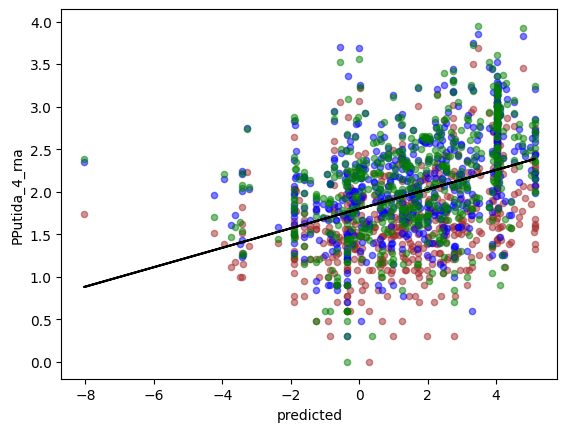

In [403]:
import statsmodels.api as sm
from scipy import stats

tmp = numpy.log10(Results).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()

X = pandas.concat([tmp[["predicted"]],tmp[["predicted"]],tmp[["predicted"]]],axis=1).stack().values
y = tmp[["PPutida_1_rna","PPutida_2_rna","PPutida_4_rna"]].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
fig,ax = plt.subplots(1,1)
tmp.plot.scatter("predicted","PPutida_1_rna",ax=ax,color="brown",alpha=0.5)
tmp.plot.scatter("predicted","PPutida_2_rna",ax=ax,color="blue",alpha=0.5)
tmp.plot.scatter("predicted","PPutida_4_rna",ax=ax,color="green",alpha=0.5)
plt.plot(X,est2.predict(),color="black")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))
